In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="L-BFGS-B",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [25]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [26]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:04,  6.16it/s]
27it [00:03,  8.87it/s]
27it [00:03,  8.74it/s]
27it [00:02, 10.70it/s]
27it [00:02, 12.13it/s]
27it [00:02, 12.05it/s]
27it [00:02, 12.18it/s]
27it [00:02, 12.83it/s]
27it [00:02, 13.22it/s]
27it [00:02, 12.27it/s]
27it [00:02, 12.28it/s]
27it [00:02, 11.52it/s]
27it [00:02, 11.81it/s]
27it [00:02, 11.72it/s]
27it [00:02, 10.03it/s]
27it [00:02, 10.77it/s]
27it [00:02,  9.60it/s]
27it [00:02, 10.44it/s]
27it [00:02, 12.05it/s]
27it [00:02, 10.20it/s]
27it [00:02, 12.50it/s]
27it [00:02, 12.19it/s]
27it [00:02, 10.96it/s]
27it [00:02, 11.81it/s]
27it [00:02, 12.13it/s]
27it [00:02, 10.38it/s]
27it [00:02, 11.66it/s]
27it [00:02, 10.83it/s]
27it [00:02, 10.67it/s]
27it [00:03,  8.23it/s]
27it [00:03,  8.17it/s]
27it [00:03,  8.95it/s]
27it [00:03,  8.94it/s]
27it [00:02,  9.47it/s]
27it [00:03,  8.25it/s]
27it [00:03,  8.09it/s]
27it [00:03,  8.13it/s]
27it [00:03,  8.04it/s]
27it [00:03,  8.66it/s]
27it [00:02,  9.82it/s]
27it [00:02, 10.73it/s]
27it [00:03,  7.

27it [00:04,  5.80it/s]
27it [00:04,  5.76it/s]
27it [00:05,  4.94it/s]
27it [00:05,  5.20it/s]
27it [00:05,  5.34it/s]
27it [00:05,  5.17it/s]
27it [00:05,  5.32it/s]
27it [00:05,  5.14it/s]
27it [00:05,  5.21it/s]
27it [00:05,  4.97it/s]
27it [00:04,  5.54it/s]
27it [00:05,  5.17it/s]
27it [00:05,  5.11it/s]
27it [00:05,  5.27it/s]
27it [00:05,  5.36it/s]
27it [00:05,  5.33it/s]
27it [00:06,  4.47it/s]
27it [00:05,  4.93it/s]
27it [00:05,  5.36it/s]
27it [00:05,  5.26it/s]
27it [00:05,  4.96it/s]
27it [00:05,  5.26it/s]
27it [00:04,  5.48it/s]
27it [00:05,  5.13it/s]
27it [00:05,  4.94it/s]
27it [00:05,  4.91it/s]
27it [00:05,  5.18it/s]
27it [00:04,  5.62it/s]
27it [00:05,  5.02it/s]
27it [00:05,  5.08it/s]
27it [00:04,  5.42it/s]
27it [00:05,  5.28it/s]
27it [00:05,  5.07it/s]
27it [00:05,  5.04it/s]
27it [00:05,  5.05it/s]
27it [00:05,  5.12it/s]
27it [00:05,  5.09it/s]
27it [00:05,  5.10it/s]
27it [00:05,  5.05it/s]
27it [00:05,  5.11it/s]
27it [00:05,  5.36it/s]
27it [00:04,  5.

27it [00:05,  5.12it/s]
27it [00:05,  5.38it/s]
27it [00:05,  5.14it/s]
27it [00:05,  5.14it/s]
27it [00:04,  5.41it/s]
27it [00:04,  5.53it/s]
27it [00:04,  5.51it/s]
27it [00:05,  5.21it/s]
27it [00:05,  4.86it/s]
27it [00:05,  5.21it/s]
27it [00:05,  4.95it/s]
27it [00:05,  4.92it/s]
27it [00:05,  4.83it/s]
27it [00:05,  4.78it/s]
27it [00:05,  4.76it/s]
27it [00:05,  5.37it/s]
27it [00:05,  5.21it/s]
27it [00:05,  5.21it/s]
27it [00:04,  5.43it/s]
27it [00:04,  5.60it/s]
27it [00:05,  5.30it/s]
27it [00:05,  4.85it/s]
27it [00:05,  5.06it/s]
27it [00:05,  4.76it/s]
27it [00:05,  5.23it/s]
27it [00:05,  5.05it/s]
27it [00:05,  5.40it/s]
27it [00:04,  5.93it/s]
27it [00:04,  5.97it/s]
27it [00:04,  5.90it/s]
27it [00:04,  5.85it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.79it/s]
27it [00:05,  5.33it/s]
27it [00:04,  5.90it/s]
27it [00:04,  5.83it/s]
27it [00:04,  5.84it/s]
27it [00:04,  5.67it/s]
27it [00:04,  5.66it/s]
27it [00:04,  5.88it/s]
27it [00:04,  5.47it/s]
27it [00:04,  5.

[0.2961138  2.2835786  5.69413042 1.33979182 3.68958701 1.42124808
 2.90965889 5.26041731 3.36674951 0.06337683 1.02646114 1.42850975
 5.35206127 2.16094494 5.28470785 0.17123754 5.92900142 1.97945306
 4.41859843 0.00743693 6.09169871 1.41933148 5.93531725 3.61117665
 0.54589534 1.9870253  1.85439738 3.42272613 3.68589176 5.0972063
 3.22481284 4.51542957]


27it [00:04,  5.88it/s]


CPU times: total: 44min 52s
Wall time: 1h 11min 57s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.453859575511139

Approximation Error
0.052006280613514054


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


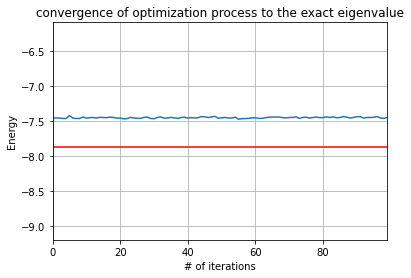

In [27]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [28]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:04,  6.11it/s]
27it [00:04,  6.01it/s]
27it [00:04,  5.87it/s]
27it [00:04,  5.86it/s]
27it [00:04,  6.37it/s]
27it [00:04,  6.18it/s]
27it [00:05,  5.33it/s]
27it [00:04,  6.03it/s]
27it [00:04,  5.74it/s]
27it [00:05,  5.21it/s]
27it [00:04,  5.74it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.79it/s]
27it [00:04,  5.99it/s]
27it [00:04,  5.66it/s]
27it [00:04,  5.89it/s]
27it [00:04,  5.89it/s]
27it [00:04,  5.80it/s]
27it [00:04,  6.13it/s]
27it [00:04,  6.34it/s]
27it [00:04,  6.39it/s]
27it [00:04,  5.59it/s]
27it [00:05,  4.82it/s]
27it [00:04,  5.91it/s]
27it [00:04,  5.71it/s]
27it [00:04,  6.08it/s]
27it [00:04,  5.86it/s]
27it [00:04,  5.91it/s]
27it [00:04,  5.96it/s]
27it [00:04,  5.83it/s]
27it [00:04,  5.74it/s]
27it [00:04,  6.11it/s]
27it [00:04,  6.74it/s]
27it [00:04,  6.55it/s]
27it [00:04,  6.07it/s]
27it [00:04,  5.64it/s]
27it [00:04,  6.00it/s]
27it [00:04,  5.76it/s]
27it [00:04,  5.88it/s]
27it [00:04,  6.07it/s]
27it [00:04,  5.94it/s]
27it [00:04,  5.

27it [00:03,  7.34it/s]
27it [00:04,  6.47it/s]
27it [00:04,  6.46it/s]
27it [00:04,  6.27it/s]
27it [00:03,  7.46it/s]
27it [00:04,  6.42it/s]
27it [00:03,  7.04it/s]
27it [00:04,  6.42it/s]
27it [00:04,  6.50it/s]
27it [00:04,  6.72it/s]
27it [00:04,  6.45it/s]
27it [00:04,  6.40it/s]
27it [00:04,  6.62it/s]
27it [00:04,  6.48it/s]
27it [00:03,  7.14it/s]
27it [00:04,  6.69it/s]
27it [00:04,  6.72it/s]
27it [00:03,  7.66it/s]
27it [00:04,  6.61it/s]
27it [00:03,  6.96it/s]
27it [00:04,  6.62it/s]
27it [00:04,  6.58it/s]
27it [00:03,  7.01it/s]
27it [00:03,  6.80it/s]
27it [00:04,  6.27it/s]
27it [00:03,  7.30it/s]
27it [00:03,  7.20it/s]
27it [00:03,  6.87it/s]
27it [00:04,  6.73it/s]
27it [00:03,  6.91it/s]
27it [00:04,  6.29it/s]
27it [00:04,  6.74it/s]
27it [00:04,  6.52it/s]
27it [00:04,  6.18it/s]
27it [00:03,  7.07it/s]
27it [00:04,  6.57it/s]
27it [00:04,  6.56it/s]
27it [00:04,  6.56it/s]
27it [00:04,  6.72it/s]
27it [00:03,  6.90it/s]
27it [00:04,  6.42it/s]
27it [00:04,  6.

27it [00:03,  7.20it/s]
27it [00:03,  8.35it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.66it/s]
27it [00:03,  7.41it/s]
27it [00:03,  8.60it/s]
27it [00:03,  7.56it/s]
27it [00:03,  7.74it/s]
27it [00:03,  7.59it/s]
27it [00:03,  7.26it/s]
27it [00:03,  7.09it/s]
27it [00:03,  6.95it/s]
27it [00:03,  6.78it/s]
27it [00:03,  8.24it/s]
27it [00:03,  8.12it/s]
27it [00:03,  7.11it/s]
27it [00:04,  6.68it/s]
27it [00:03,  7.29it/s]
27it [00:03,  7.40it/s]
27it [00:03,  7.35it/s]
27it [00:03,  8.04it/s]
27it [00:03,  6.89it/s]
27it [00:03,  7.25it/s]
27it [00:03,  7.79it/s]
27it [00:03,  7.61it/s]
27it [00:03,  7.33it/s]
27it [00:04,  6.61it/s]
27it [00:03,  8.29it/s]
27it [00:03,  8.51it/s]
27it [00:03,  7.59it/s]
27it [00:03,  7.41it/s]
27it [00:03,  7.18it/s]
27it [00:03,  7.19it/s]
27it [00:03,  7.28it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.85it/s]
27it [00:03,  8.65it/s]
27it [00:03,  7.68it/s]
27it [00:03,  7.67it/s]
27it [00:03,  7.28it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.

[5.82498552 1.41685992 1.71433332 1.99483503 0.82842601 5.59562659
 4.139073   4.6179988  2.71735419 3.0300406  1.43926739 1.02692956
 3.1674461  2.91527708 0.4370499  1.34747244 5.60027332 0.4547456
 3.31755932 5.44889679 3.86417664 4.42138519 1.83928828 4.31556429
 0.94769689 4.19742711 4.07343407 6.13611495 0.264988   5.23220678
 4.98414206 3.9426062 ]


27it [00:03,  7.77it/s]

CPU times: total: 40min 4s
Wall time: 55min 36s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.356867757172367

Approximation Error
0.06434185437708681


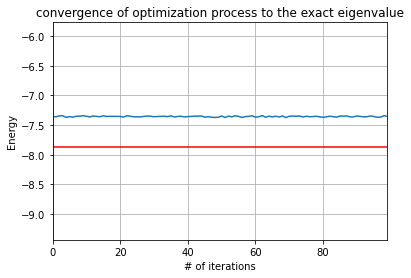

In [29]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [30]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [31]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:02,  7.23it/s]
15it [00:02,  6.44it/s]
15it [00:02,  7.14it/s]
15it [00:02,  6.79it/s]
15it [00:02,  7.28it/s]
15it [00:01,  8.13it/s]
15it [00:01,  8.20it/s]
15it [00:02,  7.32it/s]
15it [00:02,  7.28it/s]
15it [00:02,  7.41it/s]
15it [00:01,  7.82it/s]
15it [00:01,  7.66it/s]
15it [00:01,  7.65it/s]
15it [00:02,  7.25it/s]
15it [00:02,  7.07it/s]
15it [00:02,  6.50it/s]
15it [00:02,  6.87it/s]
15it [00:02,  7.44it/s]
15it [00:01,  7.90it/s]
15it [00:01,  7.73it/s]
15it [00:01,  7.54it/s]
15it [00:02,  7.47it/s]
15it [00:01,  7.67it/s]
15it [00:01,  7.83it/s]
15it [00:01,  8.96it/s]
15it [00:01,  8.95it/s]
15it [00:01,  8.99it/s]
15it [00:01,  8.78it/s]
15it [00:01,  8.22it/s]
15it [00:02,  7.19it/s]
15it [00:02,  6.98it/s]
15it [00:02,  6.56it/s]
15it [00:02,  7.47it/s]
15it [00:02,  7.03it/s]
15it [00:02,  7.33it/s]
15it [00:02,  6.91it/s]
15it [00:01,  8.64it/s]
15it [00:01,  8.36it/s]
15it [00:02,  6.89it/s]
15it [00:01,  7.56it/s]
15it [00:01,  7.58it/s]
15it [00:01,  7.

15it [00:02,  7.46it/s]
15it [00:02,  7.24it/s]
15it [00:02,  7.36it/s]
15it [00:02,  6.84it/s]
15it [00:01,  7.81it/s]
15it [00:02,  7.21it/s]
15it [00:02,  7.33it/s]
15it [00:01,  7.57it/s]
15it [00:02,  7.05it/s]
15it [00:01,  8.18it/s]
15it [00:01,  7.74it/s]
15it [00:02,  6.63it/s]
15it [00:02,  7.30it/s]
15it [00:02,  7.34it/s]
15it [00:02,  6.77it/s]
15it [00:02,  6.80it/s]
15it [00:02,  7.42it/s]
15it [00:02,  5.76it/s]
15it [00:02,  7.41it/s]
15it [00:02,  6.78it/s]
15it [00:02,  7.46it/s]
15it [00:02,  7.34it/s]
15it [00:02,  6.96it/s]
15it [00:02,  7.40it/s]
15it [00:02,  6.60it/s]
15it [00:01,  8.22it/s]
15it [00:02,  7.10it/s]
15it [00:02,  7.13it/s]
15it [00:02,  7.29it/s]
15it [00:01,  7.71it/s]
15it [00:01,  8.13it/s]
15it [00:02,  7.11it/s]
15it [00:02,  7.16it/s]
15it [00:02,  7.08it/s]
15it [00:02,  7.30it/s]
15it [00:02,  6.87it/s]
15it [00:02,  7.05it/s]
15it [00:01,  8.50it/s]
15it [00:02,  7.43it/s]
15it [00:02,  7.09it/s]
15it [00:01,  8.16it/s]
15it [00:01,  7.

15it [00:01,  9.10it/s]
15it [00:01,  8.16it/s]
15it [00:01,  9.88it/s]
15it [00:01,  8.02it/s]
15it [00:01,  8.80it/s]
15it [00:01,  8.67it/s]
15it [00:02,  7.03it/s]
15it [00:02,  7.43it/s]
15it [00:01,  8.15it/s]
15it [00:01,  8.23it/s]
15it [00:01,  8.02it/s]
15it [00:01,  8.61it/s]
15it [00:01,  8.51it/s]
15it [00:01,  8.26it/s]
15it [00:01,  8.12it/s]
15it [00:01,  7.99it/s]
15it [00:01, 10.04it/s]
15it [00:01,  9.85it/s]
15it [00:01,  8.55it/s]
15it [00:01,  9.61it/s]
15it [00:01,  8.74it/s]
15it [00:01,  8.43it/s]
15it [00:01,  9.46it/s]
15it [00:01,  8.36it/s]
15it [00:01,  9.61it/s]
15it [00:01,  9.76it/s]
15it [00:01,  8.92it/s]
15it [00:01, 10.46it/s]
15it [00:01,  9.13it/s]
15it [00:01,  8.28it/s]
15it [00:01,  9.16it/s]
15it [00:01,  8.65it/s]
15it [00:01,  9.72it/s]
15it [00:01,  7.68it/s]
15it [00:01,  8.54it/s]
15it [00:01,  7.87it/s]
15it [00:01,  8.75it/s]
15it [00:01,  9.21it/s]
15it [00:01,  8.53it/s]
15it [00:01,  9.26it/s]
15it [00:01,  8.48it/s]
15it [00:02,  7.

15it [00:01,  8.97it/s]
15it [00:01,  8.70it/s]
15it [00:01,  8.18it/s]
15it [00:01,  8.56it/s]
15it [00:01, 10.04it/s]
15it [00:01,  8.02it/s]
15it [00:01,  8.38it/s]
15it [00:01,  8.83it/s]
15it [00:01,  8.65it/s]
15it [00:01,  8.24it/s]
15it [00:01,  8.60it/s]
15it [00:01,  8.17it/s]
15it [00:01,  9.53it/s]
15it [00:01,  9.52it/s]
15it [00:01,  9.87it/s]
15it [00:01, 10.32it/s]
15it [00:01, 10.57it/s]
15it [00:01, 10.52it/s]
15it [00:01,  8.93it/s]
15it [00:01,  8.29it/s]
15it [00:01,  8.90it/s]
15it [00:01,  8.72it/s]
15it [00:01,  9.32it/s]
15it [00:01,  8.50it/s]
15it [00:01,  8.67it/s]
15it [00:01,  8.71it/s]
15it [00:01,  8.81it/s]
15it [00:01,  8.42it/s]
15it [00:01,  9.10it/s]
15it [00:01, 10.52it/s]
15it [00:01, 10.23it/s]
15it [00:01,  9.13it/s]
15it [00:01,  8.43it/s]
15it [00:01,  8.41it/s]
15it [00:01,  9.50it/s]
15it [00:01,  8.78it/s]
15it [00:01,  8.90it/s]
15it [00:01,  8.91it/s]
15it [00:01,  8.01it/s]
15it [00:01,  8.35it/s]
15it [00:01, 10.10it/s]
15it [00:01, 10.

[5.27299021 5.97306119 1.2289339  5.78823673 5.67560728 0.41546515
 4.42371127 3.07779297 1.95800476 0.21768141 3.40034747 0.53048779
 3.32109423 3.72807165 5.53886755 4.08760288 4.42640474 1.91903149
 0.87917593 4.14302909 3.06064611 4.84942134 0.56624059 2.85121354
 5.16841096 4.80153027 0.90533953 1.91821555 4.00470364 5.41111574
 1.18366499 4.37603344]


15it [00:01,  9.37it/s]

CPU times: total: 30min 50s
Wall time: 34min 33s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.7623851308161703

Approximation Error
0.5895141438836354


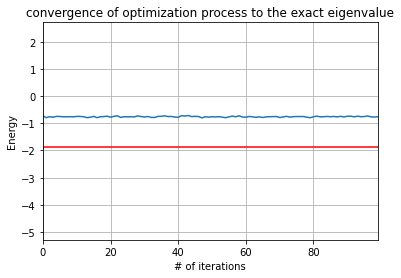

In [32]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [33]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01,  8.83it/s]
15it [00:01,  9.01it/s]
15it [00:01,  8.85it/s]
15it [00:01,  8.68it/s]
15it [00:01,  8.36it/s]
15it [00:01,  8.92it/s]
15it [00:01,  9.94it/s]
15it [00:01, 10.12it/s]
15it [00:01,  9.20it/s]
15it [00:01,  8.91it/s]
15it [00:01,  8.28it/s]
15it [00:01,  9.19it/s]
15it [00:01,  9.70it/s]
15it [00:01,  8.57it/s]
15it [00:01,  9.25it/s]
15it [00:01,  9.22it/s]
15it [00:01,  9.28it/s]
15it [00:01, 10.00it/s]
15it [00:01, 10.11it/s]
15it [00:01, 10.16it/s]
15it [00:01,  9.33it/s]
15it [00:01,  8.26it/s]
15it [00:01,  8.53it/s]
15it [00:01,  8.90it/s]
15it [00:01,  8.62it/s]
15it [00:01,  8.59it/s]
15it [00:01,  8.09it/s]
15it [00:01,  7.79it/s]
15it [00:01,  9.54it/s]
15it [00:01,  8.97it/s]
15it [00:01,  9.15it/s]
15it [00:01,  9.48it/s]
15it [00:01,  7.90it/s]
15it [00:01,  7.85it/s]
15it [00:01,  8.58it/s]
15it [00:01,  7.97it/s]
15it [00:01,  8.37it/s]
15it [00:01,  8.18it/s]
15it [00:01,  7.80it/s]
15it [00:01,  8.33it/s]
15it [00:01,  7.96it/s]
15it [00:01, 10.

15it [00:01,  8.84it/s]
15it [00:01,  9.31it/s]
15it [00:01, 10.24it/s]
15it [00:01,  9.11it/s]
15it [00:01,  8.22it/s]
15it [00:01,  8.15it/s]
15it [00:01,  8.01it/s]
15it [00:01,  9.19it/s]
15it [00:01,  8.95it/s]
15it [00:01,  8.58it/s]
15it [00:01,  9.16it/s]
15it [00:01,  8.90it/s]
15it [00:01,  8.31it/s]
15it [00:01,  9.15it/s]
15it [00:01,  8.52it/s]
15it [00:01,  9.47it/s]
15it [00:01,  9.46it/s]
15it [00:01,  9.79it/s]
15it [00:01, 10.55it/s]
15it [00:01, 10.05it/s]
15it [00:01,  8.13it/s]
15it [00:01,  9.52it/s]
15it [00:01,  8.57it/s]
15it [00:01,  8.58it/s]
15it [00:01,  8.59it/s]
15it [00:01,  9.13it/s]
15it [00:01,  8.37it/s]
15it [00:01,  8.27it/s]
15it [00:01,  8.27it/s]
15it [00:01,  8.08it/s]
15it [00:01,  9.20it/s]
15it [00:01,  8.78it/s]
15it [00:01,  9.03it/s]
15it [00:01,  9.02it/s]
15it [00:01,  7.96it/s]
15it [00:01,  8.84it/s]
15it [00:01,  8.16it/s]
15it [00:01,  7.96it/s]
15it [00:01,  8.86it/s]
15it [00:01,  9.46it/s]
15it [00:01,  8.06it/s]
15it [00:01,  8.

15it [00:01,  7.67it/s]
15it [00:01,  8.55it/s]
15it [00:01,  8.39it/s]
15it [00:01,  8.41it/s]
15it [00:01,  7.97it/s]
15it [00:01,  8.25it/s]
15it [00:01,  9.38it/s]
15it [00:01,  8.16it/s]
15it [00:01,  9.25it/s]
15it [00:01,  8.50it/s]
15it [00:01,  9.25it/s]


[1.35567213 3.8844281  2.64697677 4.47909316 0.32405382 5.99317451
 4.62785968 0.90100142 4.05770224 1.01660897 3.61077037 2.93664884
 3.97247803 1.89964087 2.28771599 2.91833063 4.01137194 3.44610521
 6.2253687  5.62373208 5.42469376 1.78923083 0.79391045 2.91938912
 2.81872948 1.60057385 1.35117373 5.88155544 3.1334827  3.90443289
 5.90133462 6.01896366]


15it [00:01,  8.60it/s]

CPU times: total: 18min 15s
Wall time: 19min 43s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.9617692275007271

Approximation Error
0.4821611167647436


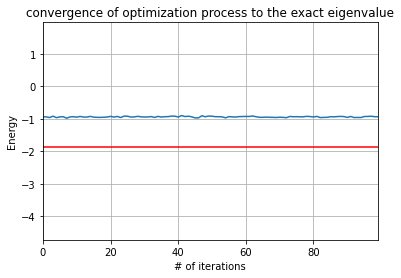

In [34]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [35]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [36]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  7.96it/s]
11it [00:01,  9.54it/s]
11it [00:01, 10.30it/s]
11it [00:01,  9.48it/s]
11it [00:01,  9.19it/s]
11it [00:01,  9.33it/s]
11it [00:01,  8.75it/s]
11it [00:01,  8.18it/s]
11it [00:01,  8.26it/s]
11it [00:01,  8.75it/s]
11it [00:01,  8.14it/s]
11it [00:01,  9.34it/s]
11it [00:01,  9.57it/s]
11it [00:01,  9.72it/s]
11it [00:01,  8.80it/s]
11it [00:01,  9.78it/s]
11it [00:01, 10.17it/s]
11it [00:01,  8.37it/s]
11it [00:01,  8.55it/s]
11it [00:01,  8.21it/s]
11it [00:01,  9.49it/s]
11it [00:01,  8.60it/s]
11it [00:01,  9.45it/s]
11it [00:01,  8.99it/s]
11it [00:01,  9.06it/s]
11it [00:01,  9.48it/s]
11it [00:01, 10.20it/s]
11it [00:01,  9.39it/s]
11it [00:01,  8.65it/s]
11it [00:01,  9.18it/s]
11it [00:01, 10.01it/s]
11it [00:01, 10.73it/s]
11it [00:01,  9.81it/s]
11it [00:01,  9.29it/s]
11it [00:01,  9.63it/s]
11it [00:01, 10.03it/s]
11it [00:01,  8.40it/s]
11it [00:01,  9.25it/s]
11it [00:01,  9.55it/s]
11it [00:01,  8.39it/s]
11it [00:01,  8.87it/s]
11it [00:01,  8.

11it [00:01,  9.62it/s]
11it [00:01,  9.58it/s]
11it [00:01,  9.03it/s]
11it [00:01,  8.99it/s]
11it [00:01,  8.03it/s]
11it [00:01,  8.88it/s]
11it [00:01,  8.98it/s]
11it [00:01,  8.89it/s]
11it [00:01,  9.41it/s]
11it [00:01, 10.06it/s]
11it [00:01, 10.67it/s]
11it [00:01, 10.34it/s]
11it [00:01,  9.04it/s]
11it [00:01,  8.56it/s]
11it [00:01,  9.24it/s]
11it [00:01,  9.97it/s]
11it [00:01,  9.22it/s]
11it [00:01,  9.38it/s]
11it [00:01, 10.12it/s]
11it [00:01,  9.60it/s]
11it [00:01,  8.64it/s]
11it [00:01,  8.53it/s]
11it [00:01,  8.61it/s]
11it [00:01,  8.79it/s]
11it [00:01,  8.55it/s]
11it [00:01,  8.61it/s]
11it [00:01,  9.26it/s]
11it [00:01,  9.98it/s]
11it [00:01, 10.44it/s]
11it [00:01,  9.24it/s]
11it [00:01,  9.25it/s]
11it [00:01,  8.82it/s]
11it [00:01, 10.00it/s]
11it [00:01,  8.73it/s]
11it [00:01,  8.84it/s]
11it [00:01,  9.60it/s]
11it [00:01,  8.92it/s]
11it [00:01,  9.05it/s]
11it [00:01,  9.66it/s]
11it [00:01,  7.94it/s]
11it [00:01,  6.68it/s]
11it [00:01,  7.

11it [00:01,  9.08it/s]
11it [00:01,  8.06it/s]
11it [00:01,  9.44it/s]
11it [00:01,  8.98it/s]
11it [00:01,  9.84it/s]
11it [00:01,  9.53it/s]
11it [00:01,  9.41it/s]
11it [00:01,  8.61it/s]
11it [00:01,  8.35it/s]
11it [00:01,  8.67it/s]
11it [00:01,  9.07it/s]
11it [00:01,  8.48it/s]
11it [00:01,  8.47it/s]
11it [00:01,  8.97it/s]
11it [00:01,  9.22it/s]
11it [00:01,  8.81it/s]
11it [00:01,  9.75it/s]
11it [00:01, 10.28it/s]
11it [00:01, 10.04it/s]
11it [00:01,  9.46it/s]
11it [00:01,  8.75it/s]
11it [00:01,  7.98it/s]
11it [00:01,  8.69it/s]
11it [00:01,  9.40it/s]
11it [00:01,  9.62it/s]
11it [00:01,  9.43it/s]
11it [00:01,  8.84it/s]
11it [00:01,  8.13it/s]
11it [00:01,  9.16it/s]
11it [00:01,  9.86it/s]
11it [00:01,  9.96it/s]
11it [00:01, 10.48it/s]
11it [00:01,  9.40it/s]
11it [00:01,  8.47it/s]
11it [00:01,  8.06it/s]
11it [00:01,  8.46it/s]
11it [00:01,  8.35it/s]
11it [00:01,  9.21it/s]
11it [00:01,  9.12it/s]
11it [00:01,  8.63it/s]
11it [00:01,  9.64it/s]
11it [00:01,  9.

[5.18917563e-01 2.57507750e+00 5.90102361e+00 1.16354767e-01
 5.74242991e-03 5.74106074e+00 4.09355050e+00 2.18416230e+00
 3.99045550e+00 9.26168336e-01 4.87797747e+00 2.00880079e+00
 3.65830007e+00 3.67317578e+00 2.95272489e-01 5.90356145e+00
 1.39879425e+00 3.98313370e+00 4.83913502e+00 1.06360141e+00
 3.91147531e+00 3.70836477e+00 3.39303999e+00 4.70767390e+00
 9.19417252e-01 6.96072675e-01 6.09780465e+00 4.72196675e+00
 2.06997566e-01 5.41720407e+00 2.34424893e-01 4.53431884e+00]


11it [00:01,  9.70it/s]

CPU times: total: 16min 6s
Wall time: 17min 22s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.10730159682854001

Approximation Error
0.9463353985144772


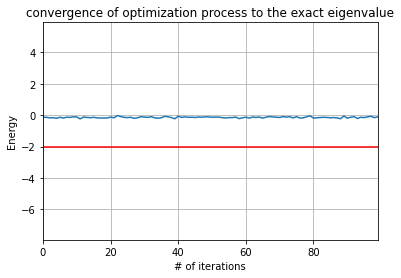

In [37]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [38]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  9.59it/s]
11it [00:01, 10.04it/s]
11it [00:01, 10.73it/s]
11it [00:01,  9.01it/s]
11it [00:01, 10.31it/s]
11it [00:01,  9.95it/s]
11it [00:01, 10.29it/s]
11it [00:01, 10.55it/s]
11it [00:00, 11.73it/s]
11it [00:00, 11.85it/s]
11it [00:00, 11.17it/s]
11it [00:01, 10.28it/s]
11it [00:01, 10.28it/s]
11it [00:01, 10.54it/s]
11it [00:01, 10.54it/s]
11it [00:01,  9.95it/s]
11it [00:01, 10.14it/s]
11it [00:01,  9.22it/s]
11it [00:01, 10.64it/s]
11it [00:01,  9.63it/s]
11it [00:00, 11.03it/s]
11it [00:01, 10.31it/s]
11it [00:01,  9.10it/s]
11it [00:01,  9.41it/s]
11it [00:01,  9.53it/s]
11it [00:01,  6.73it/s]
11it [00:01,  9.26it/s]
11it [00:01, 10.83it/s]
11it [00:01, 10.92it/s]
11it [00:01,  9.50it/s]
11it [00:00, 11.35it/s]
11it [00:00, 11.08it/s]
11it [00:00, 11.20it/s]
11it [00:01, 10.45it/s]
11it [00:01, 10.66it/s]
11it [00:00, 11.04it/s]
11it [00:01,  9.93it/s]
11it [00:01, 10.87it/s]
11it [00:01,  9.54it/s]
11it [00:01,  8.68it/s]
11it [00:01,  9.48it/s]
11it [00:01,  8.

11it [00:01,  9.60it/s]
11it [00:01, 10.06it/s]
11it [00:01,  9.32it/s]
11it [00:01, 10.06it/s]
11it [00:01,  8.71it/s]
11it [00:01,  7.77it/s]
11it [00:01, 10.21it/s]
11it [00:01, 10.48it/s]
11it [00:01,  9.93it/s]
11it [00:01,  9.69it/s]
11it [00:01, 10.17it/s]
11it [00:01,  9.08it/s]
11it [00:01,  9.36it/s]
11it [00:00, 11.42it/s]
11it [00:01, 10.19it/s]
11it [00:01,  7.64it/s]
11it [00:01,  8.63it/s]
11it [00:01,  9.69it/s]
11it [00:01,  9.91it/s]
11it [00:01,  8.36it/s]
11it [00:01,  8.06it/s]
11it [00:01, 10.10it/s]
11it [00:00, 11.46it/s]
11it [00:01,  9.67it/s]
11it [00:01, 10.32it/s]
11it [00:01,  9.69it/s]
11it [00:01,  9.24it/s]
11it [00:01, 10.28it/s]
11it [00:01, 10.16it/s]
11it [00:00, 11.57it/s]
11it [00:01,  9.89it/s]
11it [00:00, 11.39it/s]
11it [00:00, 11.42it/s]
11it [00:01,  8.99it/s]
11it [00:01, 10.38it/s]
11it [00:00, 11.54it/s]
11it [00:00, 11.00it/s]
11it [00:01, 10.03it/s]
11it [00:01,  8.94it/s]
11it [00:01,  9.87it/s]
11it [00:01,  9.69it/s]
11it [00:01,  9.

11it [00:01, 10.29it/s]
11it [00:01, 10.73it/s]
11it [00:01,  9.82it/s]
11it [00:01,  9.16it/s]
11it [00:01,  9.90it/s]
11it [00:01,  8.87it/s]
11it [00:01, 10.51it/s]
11it [00:01,  9.83it/s]
11it [00:01,  9.79it/s]
11it [00:01,  9.11it/s]
11it [00:01, 10.70it/s]
11it [00:00, 11.20it/s]
11it [00:00, 11.02it/s]
11it [00:01,  9.52it/s]
11it [00:01,  9.69it/s]
11it [00:01,  9.59it/s]
11it [00:01, 10.29it/s]
11it [00:01,  9.45it/s]
11it [00:01, 10.10it/s]
11it [00:01,  9.66it/s]
11it [00:01, 10.18it/s]
11it [00:01,  9.51it/s]
11it [00:00, 11.20it/s]
11it [00:00, 11.24it/s]
11it [00:01, 10.00it/s]
11it [00:01,  9.72it/s]
11it [00:01,  9.70it/s]
11it [00:01,  9.86it/s]
11it [00:01, 10.13it/s]
11it [00:01,  9.71it/s]
11it [00:01,  9.71it/s]
11it [00:01,  9.80it/s]
11it [00:01, 10.26it/s]
11it [00:01, 10.13it/s]
11it [00:00, 11.74it/s]
11it [00:00, 12.34it/s]
11it [00:00, 11.26it/s]
11it [00:01,  8.74it/s]
11it [00:01,  9.85it/s]
11it [00:00, 11.35it/s]
11it [00:00, 11.53it/s]
11it [00:00, 11.

[5.67489264 0.65694371 5.46476543 5.52787233 4.33011975 0.64195724
 3.42724582 0.61716786 2.38471296 1.10915557 3.67745278 4.79626
 0.52422771 3.72405284 1.10625976 3.36354078 2.64971093 3.50995074
 1.33898719 4.71933493 1.29292536 5.46638096 0.69517455 0.55986616
 5.16288788 3.90492994 5.30018828 3.15985109 3.28631918 3.08254412
 1.28362252 5.83626476]


11it [00:00, 11.46it/s]

CPU times: total: 13min 46s
Wall time: 14min 30s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
0.4098936908649

Approximation Error
0.7950004266307038


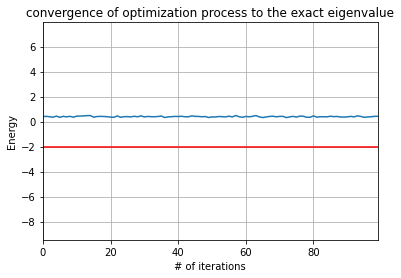

In [39]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [40]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [41]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [42]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00,  9.96it/s]
7it [00:00,  9.77it/s]
7it [00:00, 12.32it/s]
7it [00:00, 13.86it/s]
7it [00:00, 14.71it/s]
7it [00:00, 14.21it/s]
7it [00:00, 12.79it/s]
7it [00:00, 15.07it/s]
7it [00:00, 14.46it/s]
7it [00:00, 11.62it/s]
7it [00:00, 14.89it/s]
7it [00:00, 11.40it/s]
7it [00:00, 13.19it/s]
7it [00:00, 12.91it/s]
7it [00:00, 13.58it/s]
7it [00:00, 15.45it/s]
7it [00:00, 13.58it/s]
7it [00:00, 14.93it/s]
7it [00:00, 13.38it/s]
7it [00:00, 13.69it/s]
7it [00:00, 12.84it/s]
7it [00:00, 12.43it/s]
7it [00:00, 13.24it/s]
7it [00:00, 12.25it/s]
7it [00:00, 12.63it/s]
7it [00:00, 10.99it/s]
7it [00:00, 13.44it/s]
7it [00:00, 11.41it/s]
7it [00:00, 13.31it/s]
7it [00:00, 13.08it/s]
7it [00:00, 12.01it/s]
7it [00:00, 14.11it/s]
7it [00:00, 10.81it/s]
7it [00:00, 13.30it/s]
7it [00:00, 11.92it/s]
7it [00:00, 13.23it/s]
7it [00:00, 13.51it/s]
7it [00:00, 13.77it/s]
7it [00:00, 14.08it/s]
7it [00:00, 15.01it/s]
7it [00:00, 14.87it/s]
7it [00:00, 12.88it/s]
7it [00:00, 13.25it/s]
7it [00:00,

7it [00:00, 12.89it/s]
7it [00:00, 16.41it/s]
7it [00:00, 14.00it/s]
7it [00:00, 14.15it/s]
7it [00:00, 15.30it/s]
7it [00:00, 15.27it/s]
7it [00:00, 13.98it/s]
7it [00:00, 15.93it/s]
7it [00:00, 14.07it/s]
7it [00:00, 15.98it/s]
7it [00:00, 10.82it/s]
7it [00:00, 15.44it/s]
7it [00:00, 14.91it/s]
7it [00:00, 16.59it/s]
7it [00:00, 17.56it/s]
7it [00:00, 16.35it/s]
7it [00:00, 15.30it/s]
7it [00:00, 16.73it/s]
7it [00:00, 16.43it/s]
7it [00:00, 14.26it/s]
7it [00:00, 16.53it/s]
7it [00:00, 14.55it/s]
7it [00:00, 16.65it/s]
7it [00:00, 15.17it/s]
7it [00:00, 16.39it/s]
7it [00:00, 17.35it/s]
7it [00:00, 14.94it/s]
7it [00:00, 14.25it/s]
7it [00:00, 12.76it/s]
7it [00:00, 16.99it/s]
7it [00:00, 14.08it/s]
7it [00:00, 14.34it/s]
7it [00:00, 12.25it/s]
7it [00:00, 15.84it/s]
7it [00:00, 12.43it/s]
7it [00:00, 12.17it/s]
7it [00:00, 12.67it/s]
7it [00:00, 13.00it/s]
7it [00:00, 14.46it/s]
7it [00:00, 15.33it/s]
7it [00:00, 15.38it/s]
7it [00:00, 18.64it/s]
7it [00:00, 15.03it/s]
7it [00:00,

[5.61250927 0.27501319 5.15185106 3.0690896  5.90416157 5.89631576
 4.98030729 5.57155343 3.18409882 1.20614069 2.59531535 1.99806417
 2.80485224 4.20079006 0.03082376 1.51753896 3.80034998 0.35068951
 6.16030453 1.8359544  2.59416414 2.80218573 1.74211174 6.1675091 ]


7it [00:00, 17.05it/s]

CPU times: total: 4min 48s
Wall time: 4min 59s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.1162062889058495

Approximation Error
0.8974086326625254


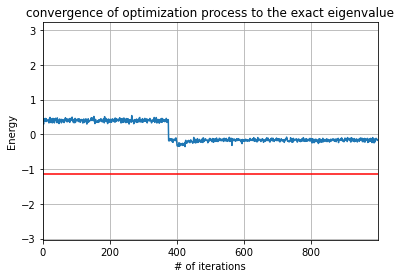

In [43]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [44]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 14.28it/s]
7it [00:00, 13.71it/s]
7it [00:00, 15.04it/s]
7it [00:00, 15.28it/s]
7it [00:00, 13.73it/s]
7it [00:00, 14.23it/s]
7it [00:00, 13.55it/s]
7it [00:00, 17.92it/s]
7it [00:00, 10.56it/s]
7it [00:00, 14.17it/s]
7it [00:00, 14.37it/s]
7it [00:00, 13.77it/s]
7it [00:00, 14.46it/s]
7it [00:00, 15.64it/s]
7it [00:00, 15.59it/s]
7it [00:00, 17.01it/s]
7it [00:00, 16.77it/s]
7it [00:00, 15.90it/s]
7it [00:00, 14.90it/s]
7it [00:00, 14.34it/s]
7it [00:00, 14.53it/s]
7it [00:00, 13.87it/s]
7it [00:00, 14.79it/s]
7it [00:00, 12.56it/s]
7it [00:00, 15.28it/s]
7it [00:00, 13.05it/s]
7it [00:00, 14.56it/s]
7it [00:00, 15.45it/s]
7it [00:00, 13.45it/s]
7it [00:00, 14.33it/s]
7it [00:00, 15.03it/s]
7it [00:00, 14.64it/s]
7it [00:00, 14.90it/s]
7it [00:00, 16.20it/s]
7it [00:00, 14.54it/s]
7it [00:00, 16.47it/s]
7it [00:00, 16.37it/s]
7it [00:00, 13.60it/s]
7it [00:00, 14.47it/s]
7it [00:00, 12.12it/s]
7it [00:00, 15.20it/s]
7it [00:00, 15.45it/s]
7it [00:00, 15.40it/s]
7it [00:00,

7it [00:00, 14.33it/s]
7it [00:00, 14.67it/s]
7it [00:00, 11.95it/s]
7it [00:00, 14.30it/s]
7it [00:00, 15.58it/s]
7it [00:00, 13.53it/s]
7it [00:00, 17.15it/s]
7it [00:00, 13.96it/s]
7it [00:00, 11.61it/s]
7it [00:00, 13.01it/s]
7it [00:00, 13.16it/s]
7it [00:00, 17.37it/s]
7it [00:00, 15.27it/s]
7it [00:00, 16.15it/s]
7it [00:00, 17.46it/s]
7it [00:00, 14.03it/s]
7it [00:00, 15.61it/s]
7it [00:00, 15.10it/s]
7it [00:00, 16.00it/s]
7it [00:00, 16.57it/s]
7it [00:00, 16.00it/s]
7it [00:00, 17.92it/s]
7it [00:00, 17.01it/s]
7it [00:00, 14.68it/s]
7it [00:00, 15.59it/s]
7it [00:00, 14.49it/s]
7it [00:00, 13.40it/s]
7it [00:00, 12.10it/s]
7it [00:00, 17.24it/s]
7it [00:00, 14.18it/s]
7it [00:00, 13.40it/s]
7it [00:00, 14.97it/s]
7it [00:00, 14.81it/s]
7it [00:00, 15.12it/s]
7it [00:00, 14.15it/s]
7it [00:00, 12.25it/s]
7it [00:00, 10.81it/s]
7it [00:00, 13.32it/s]
7it [00:00, 16.30it/s]
7it [00:00, 15.56it/s]
7it [00:00, 17.26it/s]
7it [00:00, 16.97it/s]
7it [00:00, 16.02it/s]
7it [00:00,

[5.37738731 0.85669079 0.14609635 2.85487262 0.35755708 1.46774455
 1.25550211 5.16029316 4.30377926 2.1938816  2.52481704 4.06716641
 4.24172864 5.02458816 1.82378487 1.03545665 0.68604458 5.80049386
 5.23417816 3.96685819 2.74736133 0.70331745 0.11177299 3.77160093]


7it [00:00, 15.35it/s]

CPU times: total: 3min 56s
Wall time: 4min 3s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.265123056968574

Approximation Error
0.7659392001655422


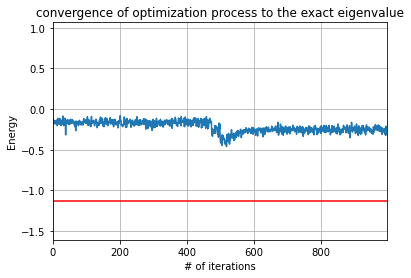

In [45]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [46]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [47]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [48]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 20.27it/s]
3it [00:00, 22.73it/s]
3it [00:00, 23.08it/s]
3it [00:00, 25.21it/s]
3it [00:00, 23.44it/s]
3it [00:00, 25.21it/s]
3it [00:00, 22.90it/s]
3it [00:00, 23.72it/s]
3it [00:00, 23.26it/s]
3it [00:00, 17.63it/s]
3it [00:00, 21.82it/s]
3it [00:00, 22.06it/s]
3it [00:00, 24.10it/s]
3it [00:00, 14.67it/s]
3it [00:00, 20.63it/s]
3it [00:00, 21.33it/s]
3it [00:00, 18.06it/s]
3it [00:00, 25.10it/s]
3it [00:00, 22.06it/s]
3it [00:00, 25.21it/s]
3it [00:00, 15.07it/s]
3it [00:00, 25.42it/s]
3it [00:00, 24.29it/s]
3it [00:00, 22.90it/s]
3it [00:00, 19.80it/s]
3it [00:00, 21.51it/s]
3it [00:00, 27.15it/s]
3it [00:00, 23.17it/s]
3it [00:00, 16.95it/s]
3it [00:00, 16.68it/s]
3it [00:00, 12.25it/s]
3it [00:00, 24.59it/s]
3it [00:00, 21.74it/s]
3it [00:00, 21.90it/s]
3it [00:00, 18.87it/s]
3it [00:00, 24.90it/s]
3it [00:00, 15.71it/s]
3it [00:00, 15.80it/s]
3it [00:00, 25.42it/s]
3it [00:00, 20.41it/s]
3it [00:00, 18.35it/s]
3it [00:00, 14.28it/s]
3it [00:00, 21.47it/s]
3it [00:00,

3it [00:00, 24.69it/s]
3it [00:00, 14.35it/s]
3it [00:00, 22.14it/s]
3it [00:00, 21.51it/s]
3it [00:00, 26.20it/s]
3it [00:00, 18.19it/s]
3it [00:00, 21.28it/s]
3it [00:00, 23.90it/s]
3it [00:00, 19.35it/s]
3it [00:00, 18.44it/s]
3it [00:00, 21.28it/s]
3it [00:00, 21.33it/s]
3it [00:00, 20.21it/s]
3it [00:00, 21.33it/s]
3it [00:00, 21.33it/s]
3it [00:00, 17.69it/s]
3it [00:00, 17.19it/s]
3it [00:00, 20.13it/s]
3it [00:00, 20.91it/s]
3it [00:00, 28.17it/s]
3it [00:00, 23.91it/s]
3it [00:00, 21.58it/s]
3it [00:00, 20.36it/s]
3it [00:00, 24.00it/s]
3it [00:00, 21.33it/s]
3it [00:00, 14.57it/s]
3it [00:00, 21.74it/s]
3it [00:00, 23.08it/s]
3it [00:00, 24.29it/s]
3it [00:00, 24.10it/s]
3it [00:00, 18.35it/s]
3it [00:00, 18.19it/s]
3it [00:00, 22.51it/s]
3it [00:00, 19.54it/s]
3it [00:00, 12.82it/s]
3it [00:00, 18.87it/s]
3it [00:00, 25.00it/s]
3it [00:00, 27.52it/s]
3it [00:00, 23.78it/s]
3it [00:00, 17.48it/s]
3it [00:00, 21.58it/s]
3it [00:00, 22.14it/s]
3it [00:00, 20.13it/s]
3it [00:00,

[0.5813259  2.54198377 2.08019962 3.59436296 4.13269752 0.54148965
 1.40986735 6.03027174 3.21073331 2.88491672 4.47540568 3.31659773
 4.08600435 3.19916376 1.19990654 3.23221617]


3it [00:00, 18.24it/s]

CPU times: total: 1min 8s
Wall time: 1min 11s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.24042850309293973

Approximation Error
0.7658865911253936


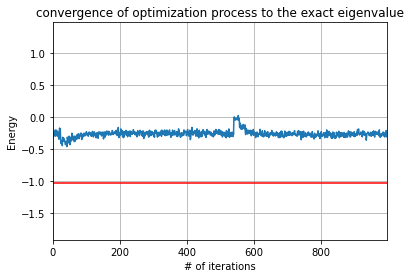

In [49]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [50]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 16.22it/s]
3it [00:00, 20.98it/s]
3it [00:00, 23.26it/s]
3it [00:00, 17.58it/s]
3it [00:00, 15.08it/s]
3it [00:00, 23.53it/s]
3it [00:00, 22.39it/s]
3it [00:00, 15.36it/s]
3it [00:00, 17.40it/s]
3it [00:00, 21.98it/s]
3it [00:00, 22.30it/s]
3it [00:00, 21.74it/s]
3it [00:00, 14.23it/s]
3it [00:00, 17.79it/s]
3it [00:00, 21.58it/s]
3it [00:00, 17.45it/s]
3it [00:00, 17.09it/s]
3it [00:00, 24.00it/s]
3it [00:00, 23.70it/s]
3it [00:00, 20.28it/s]
3it [00:00, 18.52it/s]
3it [00:00, 21.82it/s]
3it [00:00, 20.83it/s]
3it [00:00, 18.46it/s]
3it [00:00, 21.20it/s]
3it [00:00, 19.61it/s]
3it [00:00, 21.35it/s]
3it [00:00, 24.90it/s]
3it [00:00, 25.10it/s]
3it [00:00, 18.99it/s]
3it [00:00, 20.77it/s]
3it [00:00, 23.08it/s]
3it [00:00, 28.71it/s]
3it [00:00, 16.66it/s]
3it [00:00, 23.97it/s]
3it [00:00, 27.43it/s]
3it [00:00, 21.33it/s]
3it [00:00, 17.45it/s]
3it [00:00, 21.33it/s]
3it [00:00, 21.33it/s]
3it [00:00, 17.45it/s]
3it [00:00, 21.33it/s]
3it [00:00, 24.00it/s]
3it [00:00,

3it [00:00, 19.20it/s]
3it [00:00, 24.00it/s]
3it [00:00, 24.00it/s]
3it [00:00, 21.33it/s]
3it [00:00, 27.43it/s]
3it [00:00, 24.00it/s]
3it [00:00, 24.00it/s]
3it [00:00, 24.00it/s]
3it [00:00, 21.33it/s]
3it [00:00, 24.00it/s]
3it [00:00, 21.33it/s]
3it [00:00, 24.00it/s]
3it [00:00, 27.43it/s]
3it [00:00, 24.00it/s]
3it [00:00, 24.00it/s]
3it [00:00, 24.00it/s]
3it [00:00, 27.43it/s]
3it [00:00, 27.42it/s]
3it [00:00, 27.43it/s]
3it [00:00, 21.36it/s]
3it [00:00, 17.39it/s]
3it [00:00, 24.29it/s]
3it [00:00, 23.44it/s]
3it [00:00, 24.77it/s]
3it [00:00, 15.06it/s]
3it [00:00, 21.51it/s]
3it [00:00, 23.90it/s]
3it [00:00, 26.43it/s]
3it [00:00, 22.39it/s]
3it [00:00, 22.00it/s]
3it [00:00, 24.00it/s]
3it [00:00, 21.33it/s]
3it [00:00, 12.78it/s]
3it [00:00, 19.93it/s]
3it [00:00, 22.81it/s]
3it [00:00, 21.58it/s]
3it [00:00, 21.51it/s]
3it [00:00, 21.66it/s]
3it [00:00, 20.13it/s]
3it [00:00, 23.62it/s]
3it [00:00, 24.29it/s]
3it [00:00, 19.20it/s]
3it [00:00, 19.44it/s]
3it [00:00,

[5.90272779 4.06518838 4.66132896 4.50229221 5.17018166 3.73077997
 2.10394572 4.48400294 0.43606029 3.4709045  1.69723187 0.21814475
 5.16062252 5.08426793 3.93491621 5.38721227]


3it [00:00, 17.96it/s]

CPU times: total: 57.8 s
Wall time: 59.4 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.11181592749911301

Approximation Error
0.8911210292601038


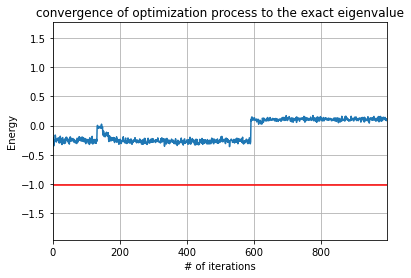

In [51]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [52]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [53]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 15.07it/s]
4it [00:00, 26.23it/s]
4it [00:00, 23.60it/s]
4it [00:00, 17.91it/s]
4it [00:00, 23.74it/s]
4it [00:00, 19.75it/s]
4it [00:00, 15.60it/s]
4it [00:00, 23.05it/s]
4it [00:00, 19.51it/s]
4it [00:00, 23.74it/s]
4it [00:00, 27.12it/s]
4it [00:00, 24.17it/s]
4it [00:00, 15.19it/s]
4it [00:00, 19.42it/s]
4it [00:00, 22.16it/s]
4it [00:00, 16.18it/s]
4it [00:00, 20.83it/s]
4it [00:00, 20.71it/s]
4it [00:00, 18.74it/s]
4it [00:00, 20.94it/s]
4it [00:00, 16.15it/s]
4it [00:00, 23.74it/s]
4it [00:00, 22.60it/s]
4it [00:00, 20.34it/s]
4it [00:00, 23.65it/s]
4it [00:00, 22.73it/s]
4it [00:00, 17.25it/s]
4it [00:00, 21.54it/s]
4it [00:00, 25.24it/s]
4it [00:00, 25.64it/s]
4it [00:00, 26.14it/s]
4it [00:00, 21.00it/s]
4it [00:00, 20.30it/s]
4it [00:00, 25.24it/s]
4it [00:00, 22.28it/s]
4it [00:00, 20.11it/s]
4it [00:00, 21.33it/s]
4it [00:00, 23.27it/s]
4it [00:00, 15.20it/s]
4it [00:00, 24.62it/s]
4it [00:00, 28.27it/s]
4it [00:00, 20.65it/s]
4it [00:00, 20.30it/s]
4it [00:00,

4it [00:00, 23.26it/s]
4it [00:00, 23.21it/s]
4it [00:00, 19.69it/s]
4it [00:00, 23.27it/s]
4it [00:00, 20.61it/s]
4it [00:00, 19.00it/s]
4it [00:00, 21.39it/s]
4it [00:00, 19.09it/s]
4it [00:00, 24.17it/s]
4it [00:00, 19.95it/s]
4it [00:00, 14.48it/s]
4it [00:00, 18.69it/s]
4it [00:00, 25.56it/s]
4it [00:00, 21.98it/s]
4it [00:00, 25.64it/s]
4it [00:00, 20.25it/s]
4it [00:00, 22.16it/s]
4it [00:00, 27.49it/s]
4it [00:00, 21.23it/s]
4it [00:00, 25.60it/s]
4it [00:00, 24.04it/s]
4it [00:00, 15.03it/s]
4it [00:00, 25.08it/s]
4it [00:00, 24.32it/s]
4it [00:00, 18.09it/s]
4it [00:00, 26.01it/s]
4it [00:00, 18.19it/s]
4it [00:00, 15.82it/s]
4it [00:00, 21.94it/s]
4it [00:00, 24.46it/s]
4it [00:00, 24.17it/s]
4it [00:00, 17.54it/s]
4it [00:00, 20.05it/s]
4it [00:00, 25.32it/s]
4it [00:00, 20.30it/s]
4it [00:00, 21.45it/s]
4it [00:00, 22.99it/s]
4it [00:00, 19.61it/s]
4it [00:00, 19.76it/s]
4it [00:00, 22.22it/s]
4it [00:00, 27.59it/s]
4it [00:00, 22.54it/s]
4it [00:00, 16.80it/s]
4it [00:00,

[4.01887791 3.12386517 3.86913289 3.67751677 6.28046259 2.39071303
 1.28475064 1.31828934 6.0553813  2.78385041 0.15426709 0.73758562
 0.03597455 6.11539605 4.61684934 6.18571624]


4it [00:00, 16.32it/s]

CPU times: total: 1min 21s
Wall time: 1min 23s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.6099630306897126

Approximation Error
0.3931360444356265


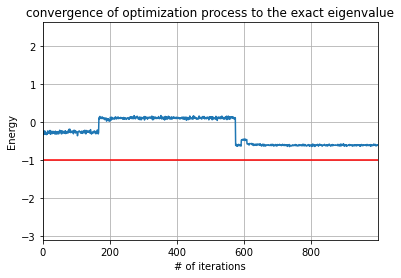

In [54]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [55]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 19.69it/s]
4it [00:00, 16.73it/s]
4it [00:00, 24.17it/s]
4it [00:00, 24.77it/s]
4it [00:00, 22.16it/s]
4it [00:00, 19.23it/s]
4it [00:00, 21.95it/s]
4it [00:00, 16.40it/s]
4it [00:00, 19.28it/s]
4it [00:00, 23.74it/s]
4it [00:00, 21.05it/s]
4it [00:00, 17.74it/s]
4it [00:00, 24.54it/s]
4it [00:00, 22.28it/s]
4it [00:00, 22.60it/s]
4it [00:00, 24.46it/s]
4it [00:00, 22.92it/s]
4it [00:00, 26.32it/s]
4it [00:00, 19.50it/s]
4it [00:00, 21.16it/s]
4it [00:00, 23.19it/s]
4it [00:00, 21.21it/s]
4it [00:00, 16.89it/s]
4it [00:00, 19.66it/s]
4it [00:00, 21.03it/s]
4it [00:00, 21.63it/s]
4it [00:00, 23.27it/s]
4it [00:00, 14.89it/s]
4it [00:00, 21.33it/s]
4it [00:00, 23.27it/s]
4it [00:00, 18.91it/s]
4it [00:00, 26.67it/s]
4it [00:00, 19.12it/s]
4it [00:00, 12.57it/s]
4it [00:00, 21.33it/s]
4it [00:00, 23.27it/s]
4it [00:00, 21.33it/s]
4it [00:00, 19.69it/s]
4it [00:00, 25.60it/s]
4it [00:00, 23.27it/s]
4it [00:00, 23.10it/s]
4it [00:00, 18.75it/s]
4it [00:00, 24.92it/s]
4it [00:00,

4it [00:00, 26.49it/s]


[0.83299195 6.17800014 0.71140833 2.34919544 3.32840398 3.79126758
 1.78998094 1.29379133 4.79745904 6.22798101 5.94315491 1.72966534
 0.20558012 4.97595858 1.9919486  5.63677597]


4it [00:00, 16.16it/s]

CPU times: total: 1min 7s
Wall time: 1min 10s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.08985582976934853

Approximation Error
0.9106007060416661


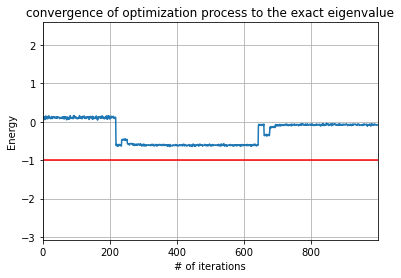

In [56]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)